# Examining feature importance using ML techniques

We explore feature importance using machine learning using Chetty's data (life expectancy in the US).

In [42]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from boruta import BorutaPy
import pickle
%matplotlib inline
plt.style.use('seaborn')

In [43]:
import os
cwd = os.getcwd()

# Data setup

In [44]:
# covariates
cov = pd.read_stata('../data/cty_full_covariates.dta')
print(cov.shape)

# life expectancy
le = pd.read_stata('../data/cty_leBY_gnd_hhincquartile.dta')
print(le.shape)

(3138, 83)
(12472, 9)


In [45]:
# life expectancy
q_values = ['Q'+i.astype('str') for i in le.hh_inc_q.unique()]
d = dict(zip(range(1,5), q_values))
le['income_q'] = le.hh_inc_q.map(d)

le.rename(columns = {'cty':'county', 'gnd':'gender', 'le_raceadj':'le'}, inplace=True)

vars = ['county', 'gender', 'income_q', 'le']
le = le.loc[:,vars]

In [46]:
le['le'] = le['le']-40.0 # life expectancy at age 40

In [47]:
# covariates 
# cov.columns

In [48]:
cov = pd.wide_to_long(cov, ['bmi_obese_q', 'cur_smoke_q', 
                            'exercise_any_q'], i='cty', j='income_q')

In [49]:
cov.reset_index(inplace=True)

In [50]:
cov.loc[cov.cty == 1003, ['income_q', 'bmi_obese_q']]

,income_q,bmi_obese_q
1,1,0.298050
3139,2,0.262467
6277,3,0.193237
9415,4,0.135747


In [51]:
cov.columns # select columns

Index(['cty', 'income_q', 'bmi_obese', 'lf_d_2000_1980',
       'adjmortmeas_pnall30day', 'puninsured2010', 'primcarevis_10',
       'scap_ski90pcm', 'amb_disch_per1000_10', 'cz_name', 'cbsa',
       'ccd_exp_tot', 'cs_born_foreign', 'diab_hemotest_10',
       'cs_fam_wkidsinglemom', 'poor_share', 'unemp_rate',
       'adjmortmeas_chfall30day', 'diab_eyeexam_10', 'num_inst_pc', 'e_rank_b',
       'reimb_penroll_adj10', 'cs_labforce', 'cs_race_theil_2000',
       'mammogram_10', 'intersects_msa', 'median_house_value', 'cs_frac_black',
       'cs00_seg_inc', 'gradrate_r', 'mig_outflow', 'med_prev_qual_z',
       'mig_inflow', 'cs_elf_ind_man', 'state_id', 'cs00_seg_inc_aff75', 'cz',
       'subcty_exp_pc', 'median_rent', 'csa_name', 'score_r', 'exercise_any',
       'frac_middleclass', 'tax_st_diff_top20', 'cty_pop2000', 'csa',
       'crime_total', 'mort_30day_hosp_z', 'cs00_seg_inc_pov25', 'cur_smoke',
       'county_name', 'taxrate', 'adjmortmeas_amiall30day', 'dropout_r',
       'cbs

In [52]:
# renaming variables 

names = ['cty', 'income_q', 'county_name', 'cty_pop2000', 'statename', 'stateabbrv', 
        'pop_density', 'gini99', 's_rank', 'e_rank_b', 'cs00_seg_inc', 
         'cs_race_theil_2000', 'hhinc00', 'poor_share', 'frac_middleclass', 
        'mig_inflow', 'mig_outflow', 'cs_born_foreign', 'rel_tot', 'crime_total',
         'puninsured2010',  'cs_labforce', 'unemp_rate', 'cs_frac_black', 'cs_frac_hisp',
         'bmi_obese_q', 'cur_smoke_q','exercise_any_q', 'median_house_value', 'cs_educ_ba', 
         'reimb_penroll_adj10', 'subcty_exp_pc'
        ]

In [53]:
nnames = ['county', 'income_q', 'county_name', 'population', 'statename', 'stateabbrv', 
        'density', 'gini', 'relative_mob', 'absolute_mob', 'segregation_income', 
          'segregation_race', 'income', 'poverty', 'middle_class', 'mig_inflow', 
          'mig_outflow', 'foreign', 'religion', 'crime_rate', 'uninsured', 
        'labor_force', 'unemployment', 'pct_black', 'pct_hispanic', 
          'obesity', 'smoking', 'exercise', 'house_value', 'college', 'medicare_expenses', 
        'local_gov_exp'
         ]


d = dict(zip(names, nnames))
cov.rename(columns=d, inplace=True)
cov = cov.loc[:, nnames]
cov['income_q']  = 'Q'+cov['income_q'].astype('str')

In [54]:
cov.head()

,county,income_q,county_name,population,statename,stateabbrv,density,gini,relative_mob,absolute_mob,...,unemployment,pct_black,pct_hispanic,obesity,smoking,exercise,house_value,college,medicare_expenses,local_gov_exp
0,1001,Q1,Autauga,43671,Alabama,AL,73.277412,0.379976,40.602394,41.872879,...,0.037379,17.008999,1.396808,0.375000,0.333333,0.500000,126368.4,18.0,9489.02,1059.669312
1,1003,Q1,Baldwin,140415,Alabama,AL,87.960236,0.489738,25.488312,44.492390,...,0.039112,10.224691,1.756222,0.298050,0.268097,0.599432,163292.5,23.1,9618.34,2209.910400
2,1005,Q1,Barbour,29038,Alabama,AL,32.814877,0.490637,42.124779,37.718758,...,0.068132,46.039669,1.646119,0.294118,0.228571,0.542857,91443.8,10.9,9761.77,1570.248291
3,1007,Q1,Bibb,20826,Alabama,AL,33.427227,0.417098,45.493622,42.245155,...,0.061639,22.010948,1.008355,0.466667,0.244444,0.422222,99441.8,7.1,11269.81,1338.441162
4,1009,Q1,Blount,51024,Alabama,AL,79.035255,0.333042,25.050438,49.043320,...,0.032847,1.171997,5.326905,0.347826,0.304348,0.565217,115704.4,9.6,10238.20,987.438843


In [55]:
# combining datasets
df = pd.merge(le, cov, left_on=['county', 'income_q'], right_on=['county', 'income_q'], how='left')
df = df.dropna(subset=['le', 'relative_mob', 'absolute_mob', 'income'])

In [56]:
df.shape

(12448, 34)

In [57]:
# create dummy variables
df['male'] = pd.get_dummies(pd.Series(df.gender), drop_first=True)
df = pd.concat([df, pd.get_dummies(pd.Series(df.income_q), drop_first=True)], axis=1) 
df.columns = df.columns.str.lower()

In [58]:
df.duplicated(['county', 'gender', 'income_q']).sum() # no duplicated values

0

# Missing data

In [59]:
from utils import utils as f

In [60]:
len(df['county'].unique()) # 1556

1556

In [61]:
df.columns

Index(['county', 'gender', 'income_q', 'le', 'county_name', 'population',
       'statename', 'stateabbrv', 'density', 'gini', 'relative_mob',
       'absolute_mob', 'segregation_income', 'segregation_race', 'income',
       'poverty', 'middle_class', 'mig_inflow', 'mig_outflow', 'foreign',
       'religion', 'crime_rate', 'uninsured', 'labor_force', 'unemployment',
       'pct_black', 'pct_hispanic', 'obesity', 'smoking', 'exercise',
       'house_value', 'college', 'medicare_expenses', 'local_gov_exp', 'male',
       'q2', 'q3', 'q4'],
      dtype='object')

In [62]:
f.missing_data(df)

crime_rate    0.062339
exercise      0.003856
smoking       0.003856
obesity       0.003856
dtype: float64

In [63]:
# impute values based on state median
by_state = df.groupby(['statename'])

# Write a function that imputes median
def impute_median(series):
    return series.fillna(series.median())

# Impute age and assign to titanic['age']
df.crime_rate = by_state['crime_rate'].transform(impute_median)
df.exercise = by_state['exercise'].transform(impute_median)
df.smoking = by_state['smoking'].transform(impute_median)
df.obesity = by_state['obesity'].transform(impute_median)

In [64]:
f.missing_data(df)

crime_rate    0.032776
exercise      0.003213
smoking       0.003213
obesity       0.003213
dtype: float64

In [65]:
df.dropna(inplace=True)

In [66]:
len(df.county.unique()) # 1500

1500

In [67]:
# plots continuous variables
variables = ['population', 'density', 'crime_rate', 'poverty', 'middle_class', 
            'mig_inflow', 'mig_outflow', 'foreign', 'pct_black', 'pct_hispanic', 
            'religion', 'uninsured', 'medicare_expenses', 'house_value', 'local_gov_exp', 
            'college', 'obesity', 'exercise', 'smoking', 'unemployment', 
            'labor_force', 'income',  'segregation_income', 'segregation_race']

len(variables)

24

In [68]:
df.mig_inflow.describe()

count    12000.000000
mean         0.034705
std          0.019210
min          0.006001
25%          0.021230
50%          0.030055
75%          0.042575
max          0.168671
Name: mig_inflow, dtype: float64

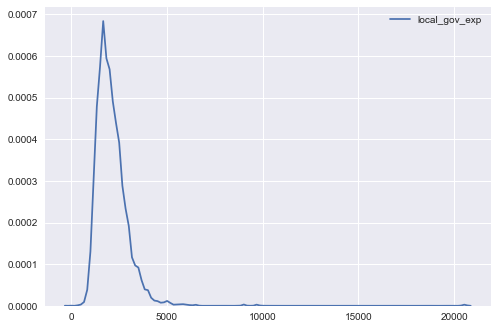

In [69]:
sns.kdeplot(df.loc[:, 'local_gov_exp']);
# sns.kdeplot(df.loc[:, variables[23]]);
# sns.kdeplot(np.log(df.loc[:, variables[23]]), label='log');

In [70]:
log_variables = ['population', 'crime_rate', 'poverty', 'mig_inflow', 
            'mig_outflow', 'foreign', 'pct_black', 'pct_hispanic', 
            'house_value', 'local_gov_exp', 'unemployment', 'income']
len(log_variables)

12

In [71]:
df_tr = f.transform_variables(df, variables=log_variables, kind='log')

In [72]:
z_variables = ['gini', 'relative_mob', 'absolute_mob', 
            'middle_class', 'segregation_income', 'religion', 
            'labor_force', 'uninsured', 'medicare_expenses', 
            'college', 'obesity', 'smoking', 'exercise' ]
df_tr = f.transform_variables(df_tr, variables=z_variables, kind='z')

In [73]:
len(log_variables)+len(z_variables)

25

In [74]:
df_tr.duplicated(['county', 'gender', 'income_q']).sum()

0

In [75]:
df_tr.columns

Index(['county', 'gender', 'income_q', 'le', 'county_name', 'population',
       'statename', 'stateabbrv', 'density', 'gini', 'relative_mob',
       'absolute_mob', 'segregation_income', 'segregation_race', 'income',
       'poverty', 'middle_class', 'mig_inflow', 'mig_outflow', 'foreign',
       'religion', 'crime_rate', 'uninsured', 'labor_force', 'unemployment',
       'pct_black', 'pct_hispanic', 'obesity', 'smoking', 'exercise',
       'house_value', 'college', 'medicare_expenses', 'local_gov_exp', 'male',
       'q2', 'q3', 'q4', 'log_population', 'log_crime_rate', 'log_poverty',
       'log_mig_inflow', 'log_mig_outflow', 'log_foreign', 'log_pct_black',
       'log_pct_hispanic', 'log_house_value', 'log_local_gov_exp',
       'log_unemployment', 'log_income', 'z_gini', 'z_relative_mob',
       'z_absolute_mob', 'z_middle_class', 'z_segregation_income',
       'z_religion', 'z_labor_force', 'z_uninsured', 'z_medicare_expenses',
       'z_college', 'z_obesity', 'z_smoking', 'z_ex

In [76]:
df_tr.to_csv('../data/le_cov_all.csv',index=False)

In [77]:
# subset variables

# -Demographic: % Black, Hispanic (since Chetty uses this to race adjust)
# -Social: Crime rate, segregation
# -Economic: Gini, possibly unemployment
# -Health Access: uninsured, medicare expenses

subset_vars = ['le', 'z_relative_mob', 'z_gini', 'county', 'gender', 'income_q', 'county_name', 'stateabbrv', 
               'statename', 'log_population', 'log_income', 'z_segregation_income', 'log_unemployment',
               'z_uninsured', 'z_medicare_expenses', 'log_crime_rate', 'log_pct_black', 
               'log_pct_hispanic', 'z_obesity', 'z_smoking', 'z_exercise'] 

In [78]:
df_sel = df_tr.loc[:, subset_vars]

In [79]:
df_sel.to_csv('../data/le_cov_sel.csv', index=False)

In [80]:
f.missing_data(df_sel)

No missing data!


# Split data (training, validation, test set)

In [81]:
# split dataset 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

In [82]:
y = df.loc[:,'le'].as_matrix()

In [83]:
varnames = list(df.columns)

In [84]:
states = list(filter(re.compile(r'state_').search, varnames))

In [85]:
# define covariates
covariates = ['population', 'density', 'gini', 'relative_mob', 
              'segregation_income', 'income', 'poverty', 'middle_class', 'local_gov_exp', 
              'house_value', 'religion', 'medicare_expenses', 'college',
              'mig_inflow', 'mig_outflow', 'foreign', 'crime_rate', 'uninsured', 
              'labor_force', 'unemployment', 'pct_black', 'pct_hispanic',  'obesity', 'smoking', 
              'exercise', 'male', 'q2', 'q3', 'q4'
             ]

In [86]:
# split data sets using stratification
strata =  df.loc[:,['male', 'q2', 'q3', 'q4']].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,covariates],
                                                    y, 
                                                    random_state=42, stratify=strata, 
                                                   test_size=0.20)

In [87]:
# update strata
strata = X_train.loc[:,['male', 'q2', 'q3', 'q4']].as_matrix()
X_strain, X_val, y_strain, y_val = train_test_split(X_train, y_train, 
                                                    random_state=42, 
                                                    test_size=0.20,
                                                    stratify=strata)

In [88]:
X_strain.shape

(7680, 29)

In [89]:
# features
features = X_strain.columns.tolist()

# Baseline (average model)

Baseline model to compare performance.

In [90]:
# baseline using mean

from sklearn import base

class averageEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self):
        self.avg = 0.0
    
    def fit(self, X, y):
        self.avg = y.mean()
        return self
    
    def predict(self, X): 
        return [self.avg for row in X]

In [91]:
baseline_model = averageEstimator()

In [92]:
X_val.shape

(1920, 29)

In [93]:
baseline_model.fit(X_strain.as_matrix(), y_strain)

averageEstimator()

In [94]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

np.sqrt(mean_squared_error(y_val, baseline_model.predict(X_val.as_matrix())))

3.6114225

# Regression 

Just plain linear regression, with all the predictors (i.e., also mediators)

In [95]:
from sklearn import  linear_model, utils, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

In [96]:
# reg_estimator = Pipeline([('imputer', Imputer(missing_values=np.nan,
#                                           strategy='mean',
#                                           axis=0)),
#                           ('regression', linear_model.LinearRegression(fit_intercept=True))
#                          ])

reg_est = linear_model.LinearRegression(fit_intercept=True)

In [97]:
reg_est.fit(X_strain.as_matrix(), y_strain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [98]:
np.sqrt(mean_squared_error(y_val, reg_est.predict(X_val.as_matrix())))

1.4697723128137654

Not bad reduction!

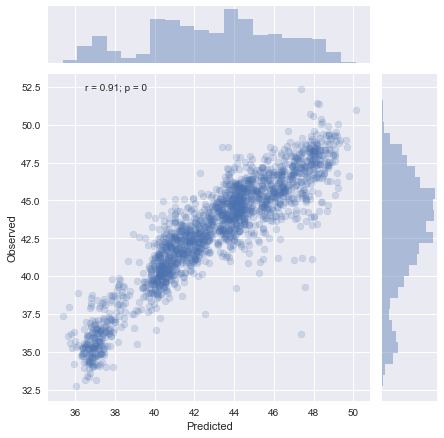

In [99]:
g = sns.jointplot(reg_est.predict(X_val.as_matrix()),y_val, alpha=0.20, 
                  annot_kws=dict(stat="r"))
g.set_axis_labels(xlabel='Predicted', ylabel='Observed');

There is a problem when predicting the bottom of the distribution, an split in the predicted values at LE 80 that is not observed in the data. 

# Random forest

Let's start just exploring the parameter space and selecting the best random forest setup. 

In [100]:
from sklearn.ensemble import RandomForestRegressor

In [101]:
rf_reg = RandomForestRegressor(n_estimators=1000, random_state=123)

In [102]:
rf_reg.fit(X_strain.as_matrix(), y_strain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

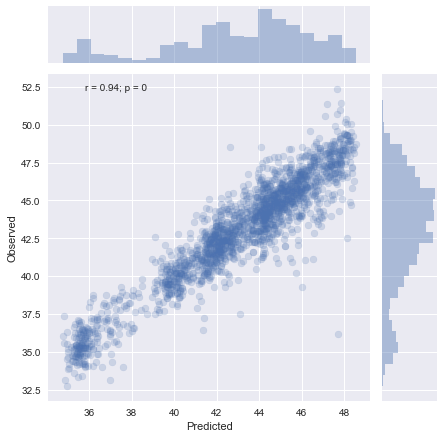

In [103]:
g = sns.jointplot(rf_reg.predict(X_val.as_matrix()),y_val, alpha=0.20, 
                  annot_kws=dict(stat="r"))
g.set_axis_labels(xlabel='Predicted', ylabel='Observed');

In [104]:
np.sqrt(mean_squared_error(y_val, rf_reg.predict(X_val.as_matrix())))

1.2639451864061

In [105]:
# function to create feature importance plot
def importance_plot(feature_importance, features, thresold = 0.0):
    im = sorted(zip(map(lambda x: round(x, 3), feature_importance), 
           features))
    im  = pd.DataFrame(im, columns=['importance', 'feature'])
    im = im.loc[im.importance > thresold,:] # filter
    plot = im.plot.barh(x='feature',legend=None)
    plt.ylabel('Features')
    plt.xlabel('Importance')
    return plot

### Variable importance

In [106]:
importances = rf_reg.feature_importances_

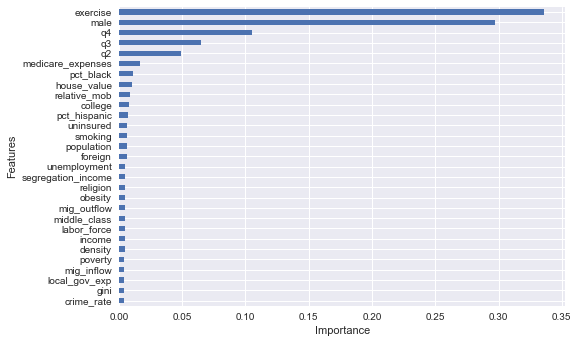

In [107]:
importance_plot(importances, features);

In [108]:
# find all relevant features using boruta
# feat_selector = BorutaPy(rf_reg, n_estimators='auto', verbose=2)
# feat_selector.fit(X_strain.as_matrix(), y_strain)
# np.asarray(features)[~feat_selector.support_]

So, the key demographic variables (gender and income quartile) are the strongest predictors. Mobility improves predictions only slightly. These scores are tricky to interpret because of the correlation between features. 

# Assessing predictions on the test set

### Regression

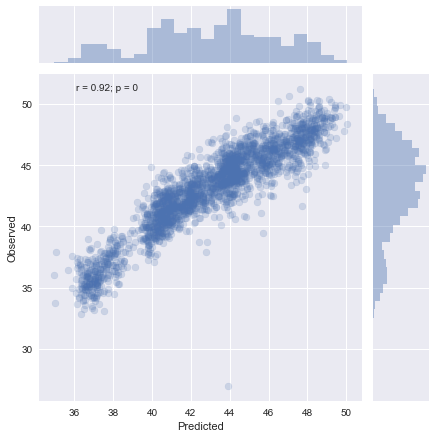

In [109]:
g = sns.jointplot(reg_est.predict(X_test.as_matrix()), y_test, alpha=0.20, 
                  annot_kws=dict(stat="r"))
g.set_axis_labels(xlabel='Predicted', ylabel='Observed');

In [110]:
np.sqrt(mean_squared_error(reg_est.predict(X_test.as_matrix()), y_test)) 

1.4034167097542891

### Random Forest

In [111]:
X_test.shape

(2400, 29)

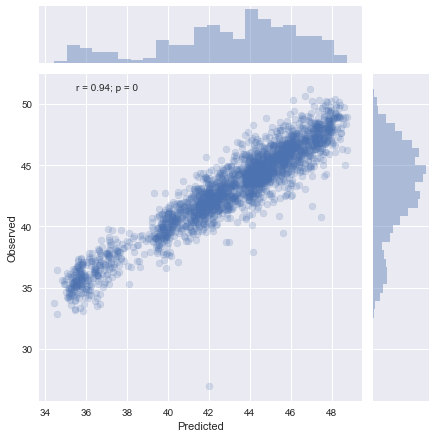

In [112]:
g = sns.jointplot(rf_reg.predict(X_test.as_matrix()), y_test, alpha=0.20, 
                  annot_kws=dict(stat="r"))
g.set_axis_labels(xlabel='Predicted', ylabel='Observed');

In [114]:
np.sqrt(mean_squared_error(rf_reg.predict(X_test.as_matrix()), y_test))

1.2230286300440811

Random forests make a better job predicting the test set, even with scarce tunning.